It looks like the data was in pretty good shape from your last file 'data_cleaning.ipynb.' Now we should move on to answering questions the marketing team has for you in your interview: Customer Segments, Product Information, and Marketing Return on Investment.

Customer Segment Questions:
1. Segment customers based on demographic data (age, gender, location)
2. Which demographics represent High Frequency Customers? 
3. Which demographics represent Low Frequency Customers?
4. HF vs. LF customers more likely to use a discount code?
5. Average Order Value from High Frequency Customers, AOV for Low Frequency Customers

Product Information Questions:
1. Which products have the highest conversion rate?
2. Top seasonality by total sales 
3. Total sales amount by marketing campaign
4. Total sales amount by month

Marketing Return on Investment:
1. Compare CPAs for Tik Tok vs. Email 
2. Which marketing campaigns had the highest conversions?

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import random
import sqlite3
import sqlalchemy

You start exploring their customer base via customer demographics - a good place to start would be age, gender and location. 

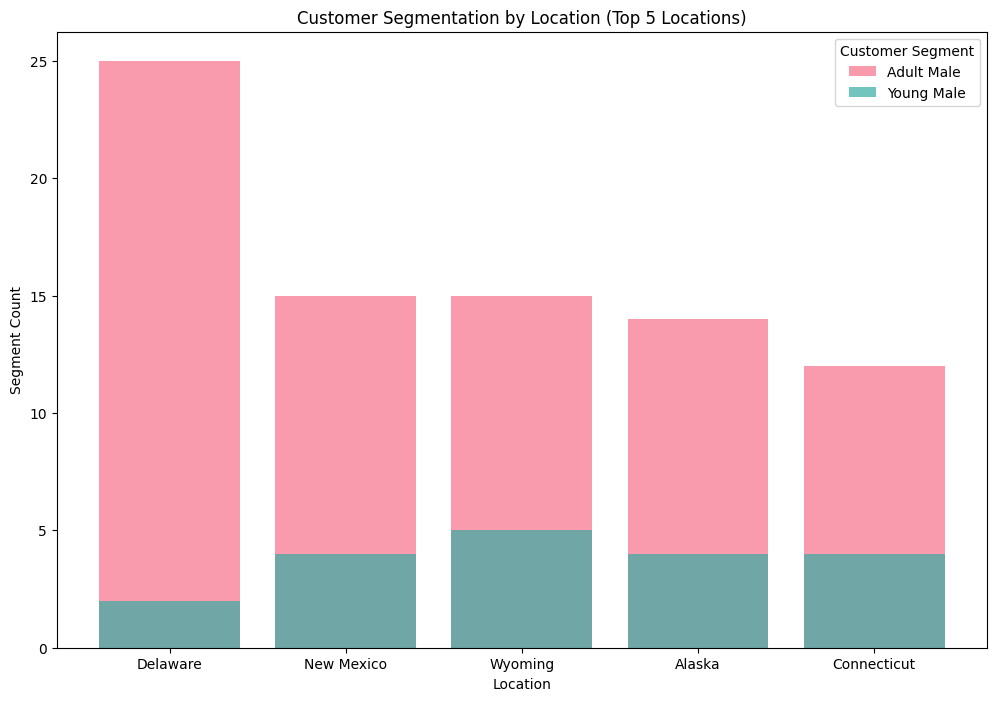

In [4]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

customer_segment_1 = '''
    SELECT
    Location,
    CASE
    WHEN Age < 30 AND Gender = 'Female' THEN 'Young Female'
    WHEN Age < 30 AND Gender = 'Male' THEN 'Young Male'
    WHEN Age >= 30 AND Gender = 'Female' THEN 'Adult Female'
    WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
    ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
    FROM merged_data
    GROUP BY Location, Customer_Segment
    ORDER BY Segment_Count DESC;
    '''
customer_segment_1 = pd.read_sql(customer_segment_1, conn)

top_locations = customer_segment_1['Location'].value_counts().nlargest(5).index
customer_segment_1_top5 = customer_segment_1[customer_segment_1['Location'].isin(top_locations)]

# Plotting the bar graph with different colors
plt.figure(figsize=(12, 8))

# Use seaborn color palette for distinct colors
colors = sns.color_palette('husl', n_colors=len(customer_segment_1_top5['Customer_Segment'].unique()))

#Create list to iterate through top 5 customer segments, grouping by the SQL customer segment 
for i, (seg, group) in enumerate(customer_segment_1_top5.groupby('Customer_Segment')):
    plt.bar(
        group['Location'],
        group['Segment_Count'],
        label=seg,
        color=colors[i],
        alpha=0.7
    )
#Create bar graph - the X-axis will be the grouped top 5 locations, the Y-axis will be the amount of grouped Segment Counts (Adult Male and Young Male)
plt.xlabel('Location')
plt.ylabel('Segment Count')
plt.title('Customer Segmentation by Location (Top 5 Locations)')
plt.legend(title='Customer Segment')
plt.show()

Interesting, so far it looks like our top customer segments between 2020-2023 were Adult Males in the states of Delaware, New Mexico, Wyoming, Alaska and Connecticut. 
Let's see if we can find our how often Adult Males are purchasing inventory by categorizing their spending patterns into High Frequency and Low Frequency segments. 

In [5]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

customer_segment_2 = '''
SELECT
    Location,
    CASE
        WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
        ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
FROM merged_data
WHERE Frequency_of_Purchases IN ("Weekly", "Biweekly", "Monthly") 
GROUP BY Location, Customer_Segment
ORDER BY Segment_Count DESC;
'''
customer_segment_2 = pd.read_sql(customer_segment_2, conn)

# Display the dataframe
print(customer_segment_2)
conn.close()

         Location Customer_Segment  Segment_Count
0          Nevada       Adult Male             11
1        Delaware       Adult Male             10
2            Iowa       Adult Male              9
3   Massachusetts       Adult Male              9
4           Idaho       Adult Male              8
..            ...              ...            ...
84   South Dakota            Other              1
85      Tennessee            Other              1
86           Utah            Other              1
87  West Virginia            Other              1
88        Wyoming            Other              1

[89 rows x 3 columns]


In [6]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

customer_segment_3 = '''
SELECT
    Location,
    CASE
        WHEN Age >= 30 AND Gender = 'Male' THEN 'Adult Male'
        ELSE 'Other'
    END AS Customer_Segment,
    COUNT(*) AS Segment_Count
FROM merged_data
WHERE Frequency_of_Purchases IN ("Quarterly","Annually") 
GROUP BY Location, Customer_Segment
ORDER BY Segment_Count DESC;
'''
customer_segment_3 = pd.read_sql(customer_segment_3, conn)

# Display the dataframe
print(customer_segment_3)
conn.close()

          Location Customer_Segment  Segment_Count
0     North Dakota       Adult Male             13
1        Minnesota       Adult Male             12
2   South Carolina       Adult Male             12
3         Missouri       Adult Male             11
4         Oklahoma       Adult Male             11
..             ...              ...            ...
87      New Jersey            Other              1
88      New Mexico            Other              1
89  North Carolina            Other              1
90            Ohio            Other              1
91    Rhode Island            Other              1

[92 rows x 3 columns]


It looks like their most frequent purchasers (High Frequency) are in the states of Nevada, Delaware, Iowa, Massachusetts and Idaho. Whereas your low frequency purchasers are in the states of Missouri, Oklahoma, South Carolina, Colorado and Florida. This is important to note when comparing to the first visualization which is a generalization of all historical customers.

  Frequency_of_Purchases Discount_Applied  last_purchase_month  Usage_Count
0              Bi-Weekly              Yes                   11           37
1              Quarterly              Yes                    8           35
2              Quarterly              Yes                    7           29
3              Bi-Weekly              Yes                    5           28
4              Quarterly              Yes                    4           28


/var/folders/0w/vbrv_qbd3h59qw608swcmv3m0000gn/T/ipykernel_4508/2783781896.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Frequency_of_Purchases', y='Usage_Count', hue='last_purchase_month', data=customer_segment_4, ci=None, palette="GnBu")


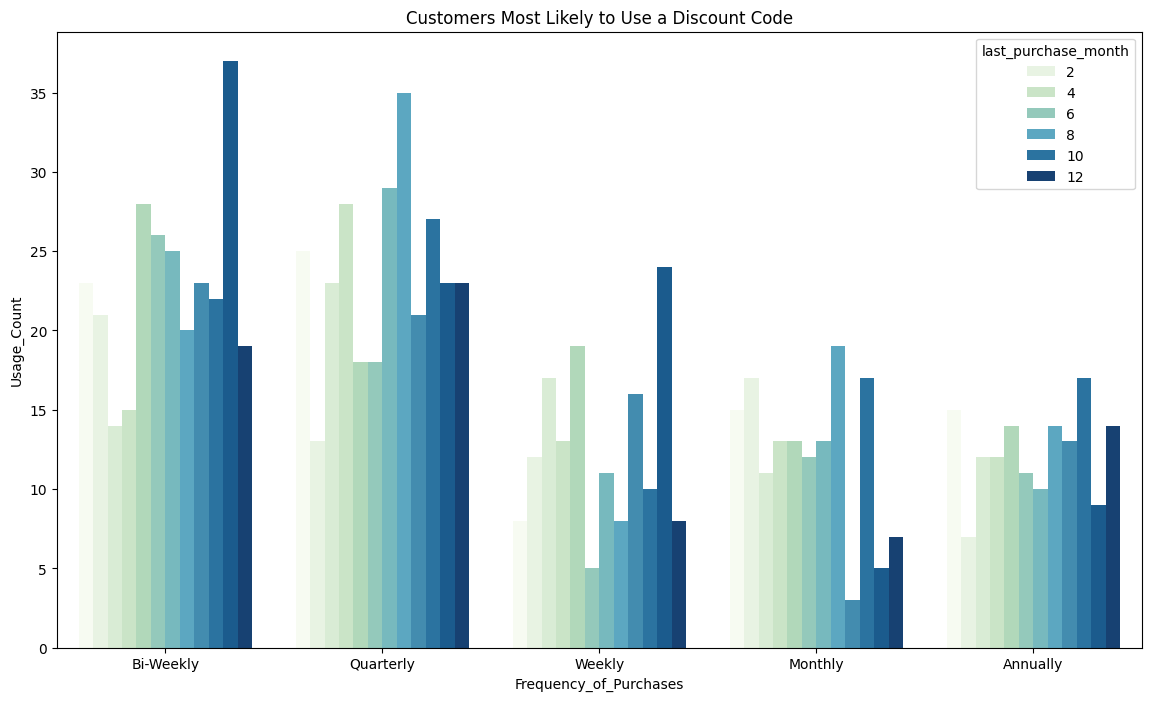

In [7]:
#Customer Segment #4:
#Are High Frequency Customers or Low Frequency Customers more likely to use a discount code? In what month are they more likely to use a discount code?
#If High Frequency then Frequency_of_Purchases = weekly, biweekly, monthly;  if Low Frequency then Frequency_of_Purchases = quarterly, yearly;

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

customer_segment_4 = '''
SELECT
    Frequency_of_Purchases,
    Discount_Applied,
    last_purchase_month,
    COUNT(*) AS Usage_Count
FROM
    merged_data
GROUP BY
    Frequency_of_Purchases, Discount_Applied, last_purchase_month
ORDER BY
    Usage_Count DESC;

'''

customer_segment_4 = pd.read_sql(customer_segment_4, conn)

# Display the dataframe
print(customer_segment_4.head())
conn.close()

#Plot the bar graph
plt.figure(figsize=(14, 8))
#Use seaborn GnBu color palette for bar graph colors. Use the function 'hue' to display the different months where a customer segment would use a discount code.
sns.barplot(x='Frequency_of_Purchases', y='Usage_Count', hue='last_purchase_month', data=customer_segment_4, ci=None, palette="GnBu")
plt.title('Customers Most Likely to Use a Discount Code')
plt.show()

Aggregating the Frequency Groups over the past 3 years of sales data, it looks like the Frequency_Segment group Bi-Weekly, Quarterly, and Weekly are the groups most likely to use a discount code during the Q2 and Q4 months. 

In [8]:
#Customer Segment #5: Average Order Value from High Frequency Customers 
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

customer_segment_5 = '''
SELECT Frequency_of_Purchases, AVG (Purchase_Amount_USD)
FROM merged_data
GROUP BY Frequency_of_Purchases;
'''

customer_segment_5 = pd.read_sql(customer_segment_5, conn)
print(customer_segment_5)
conn.close()

  Frequency_of_Purchases  AVG (Purchase_Amount_USD)
0               Annually                  58.662162
1              Bi-Weekly                  59.102564
2                Monthly                  59.034483
3              Quarterly                  61.222615
4                 Weekly                  59.271523


We want to ask this questions to see our highest value segment. It's often better to keep targeting groups with a higher order value versus those that do not. However, it looks like in this customer data all segments are relatively close in terms of average order value. 

   Item_Purchased     tiktok_campaign  COUNT (tiktok_conversion)  \
0         Sandals       we missed you                         16   
1          Hoodie      product launch                         31   
2            Coat       cross product                         49   
3         Sweater      abandoned cart                         20   
4         T-shirt      abandoned cart                          6   
5        Backpack      product launch                          8   
6             Hat      product launch                         25   
7           Pants  frequency purchase                         24   
8           Shirt       cross product                        104   
9          Jacket      abandoned cart                          2   
10          Socks             welcome                         46   
11           Coat             welcome                          6   
12          Pants             welcome                         13   
13            Hat       we missed you           

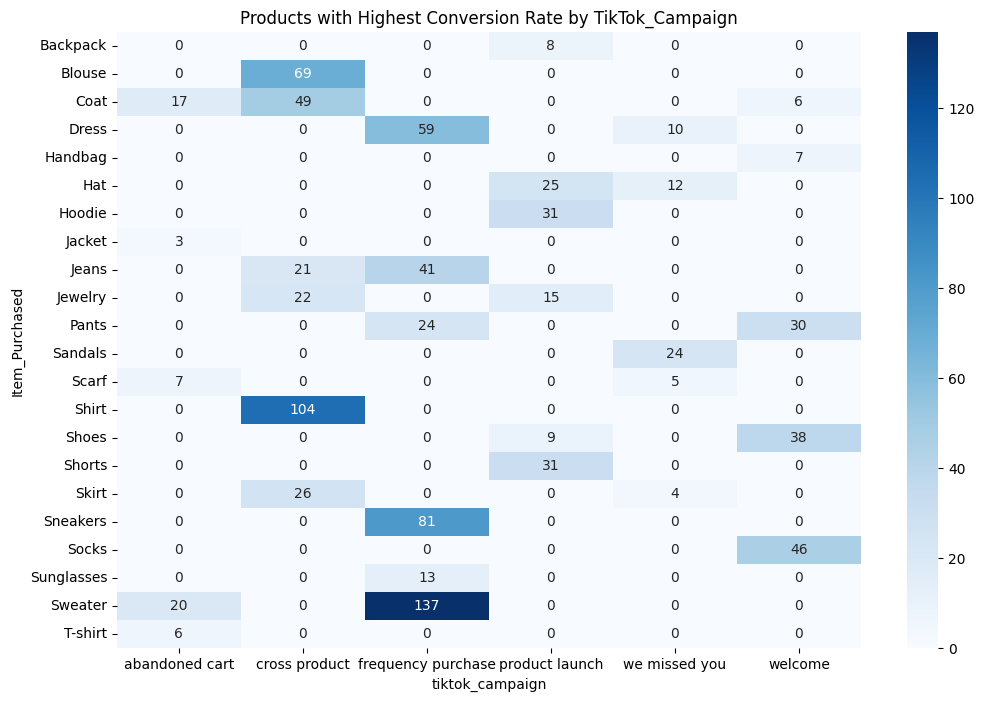

In [9]:
#Product Information #1:  Which products had the highest conversion rate?

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_1a = '''
SELECT Item_Purchased, tiktok_campaign, COUNT (tiktok_conversion), email_campaign, COUNT (email_conversion)
FROM merged_data
GROUP BY tiktok_campaign, email_campaign
ORDER BY tiktok_conversion DESC, email_conversion DESC;
'''

product_information_1a = pd.read_sql(product_information_1a, conn)
print(product_information_1a)

#Set a pivot table variable where the Index is the Item_Purchased column, and our columns:values are the Tiktok_Campaigns and their count of Conversions.
pivot_table = product_information_1a.pivot_table(index='Item_Purchased', columns='tiktok_campaign', values='COUNT (tiktok_conversion)', aggfunc='sum', fill_value=0)

# Plotting the heatmap with blues and greens colormap, using the pivot table variable as the dataset 
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
plt.title('Products with Highest Conversion Rate by TikTok_Campaign')
plt.show()

The different hues call out the highest conversion rates by product and by TikTok campaign. Here is looks like sweaters x Frequency Purchase campaign produced 137 conversions. Second to that would be Shirts x Cross Product campaigns and 3rd to that would be Sneakers x Frequency Purchase.

   Item_Purchased     tiktok_campaign  COUNT (tiktok_conversion)  \
0         Sandals       we missed you                         16   
1          Hoodie      product launch                         31   
2            Coat       cross product                         49   
3         Sweater      abandoned cart                         20   
4         T-shirt      abandoned cart                          6   
5        Backpack      product launch                          8   
6             Hat      product launch                         25   
7           Pants  frequency purchase                         24   
8           Shirt       cross product                        104   
9          Jacket      abandoned cart                          2   
10          Socks             welcome                         46   
11           Coat             welcome                          6   
12          Pants             welcome                         13   
13            Hat       we missed you           

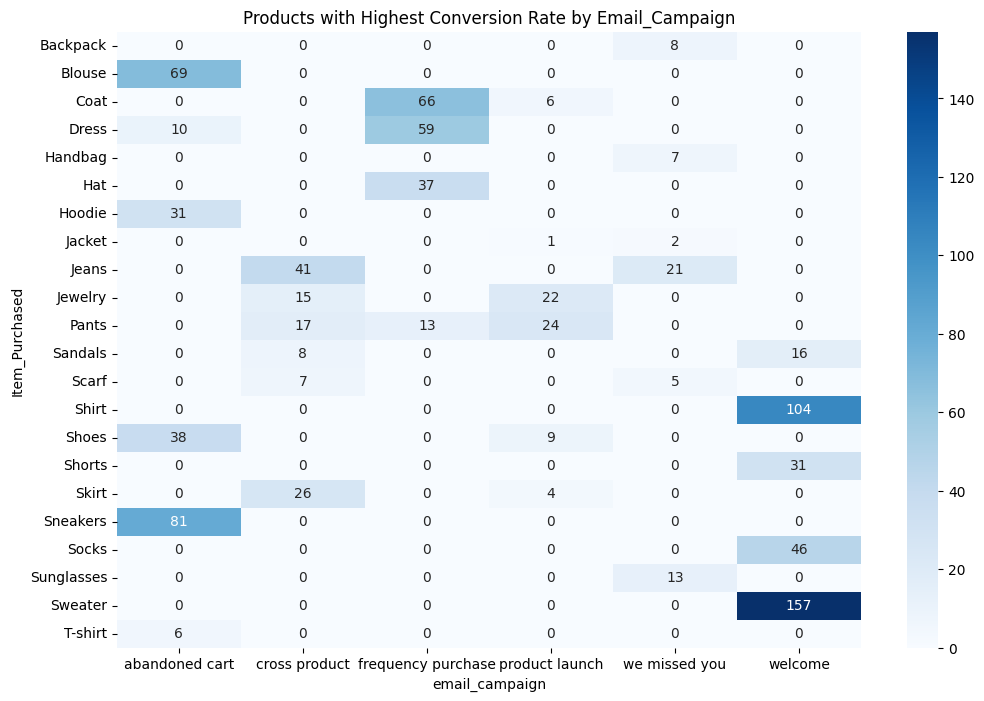

In [10]:
product_information_1b = '''
SELECT Item_Purchased, tiktok_campaign, COUNT (tiktok_conversion), email_campaign, COUNT (email_conversion)
FROM merged_data
GROUP BY tiktok_campaign, email_campaign
ORDER BY tiktok_conversion DESC, email_conversion DESC;
'''

product_information_1b = pd.read_sql(product_information_1b, conn)
print(product_information_1b)

pivot_table = product_information_1b.pivot_table(index='Item_Purchased', columns='email_campaign', values='COUNT (email_conversion)', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
plt.title('Products with Highest Conversion Rate by Email_Campaign')
plt.show()

For email marketing efforts, it looks like Welcome emails x Sweaters produced 157 conversions, Abandoned Cart x Sneakers produced 81 conversions, and shirts produced 104 conversions from the Welcome Email campaign. 

In [11]:
#Product Information #2 Total Sales Amount for seasonal clothing

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_2 = '''
SELECT Season, Total (Purchase_Amount_USD) DESC
FROM merged_data
GROUP BY Season;
'''

product_information_2 = pd.read_sql(product_information_2, conn)
print(product_information_2)

   Season     DESC
0    Fall  15430.0
1  Spring  15220.0
2  Summer  14357.0
3  Winter  14646.0


It looks like the shoulder seasons of Spring and Fall have slightly higher total purchases over the past 3 years. Could be good information when evaluating the timing of marketing efforts. Let's see if we can dig into the Total Sales (different than conversions) by marketing campaign and by month. 

     email_campaign  Total_Purchase_Amount
0    abandoned cart                     94
1    abandoned cart                     36
2    abandoned cart                     23
3    abandoned cart                     53
4    abandoned cart                     32
..              ...                    ...
828         welcome                     92
829         welcome                     44
830         welcome                     89
831         welcome                     78
832         welcome                     62

[833 rows x 2 columns]


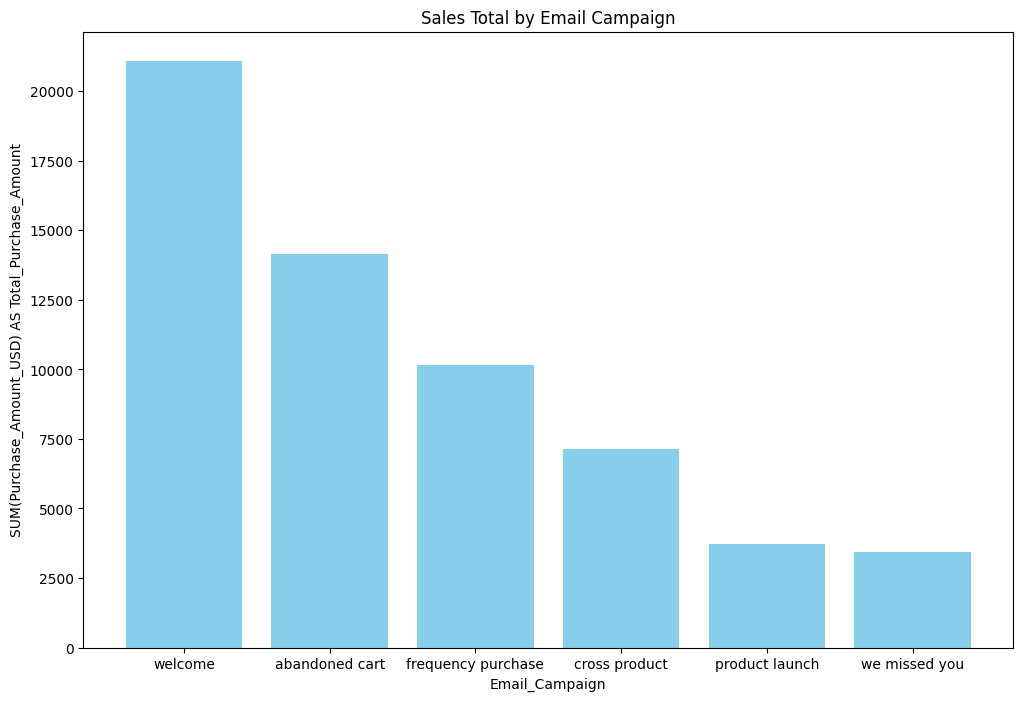

In [22]:
#Product Information #3: Total sales amount by marketing campaigns and month

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_3 = '''
SELECT
    email_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
'''

product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with email campaigns (Total_Purchase_Amount) and group by the associated email campaign, sort by descending values
email_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['email_campaign']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("Email_Campaign")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Sales Total by Email Campaign")
plt.show()

It looks like the Welcome Email was the event that resulted in most sales.

     email_campaign  last_purchase_month  Total_Purchase_Amount
0    abandoned cart                    3                     94
1    abandoned cart                    1                     36
2    abandoned cart                    8                     23
3    abandoned cart                    3                     53
4    abandoned cart                    7                     32
..              ...                  ...                    ...
828         welcome                    9                     92
829         welcome                   11                     44
830         welcome                    2                     89
831         welcome                    4                     78
832         welcome                    5                     62

[833 rows x 3 columns]


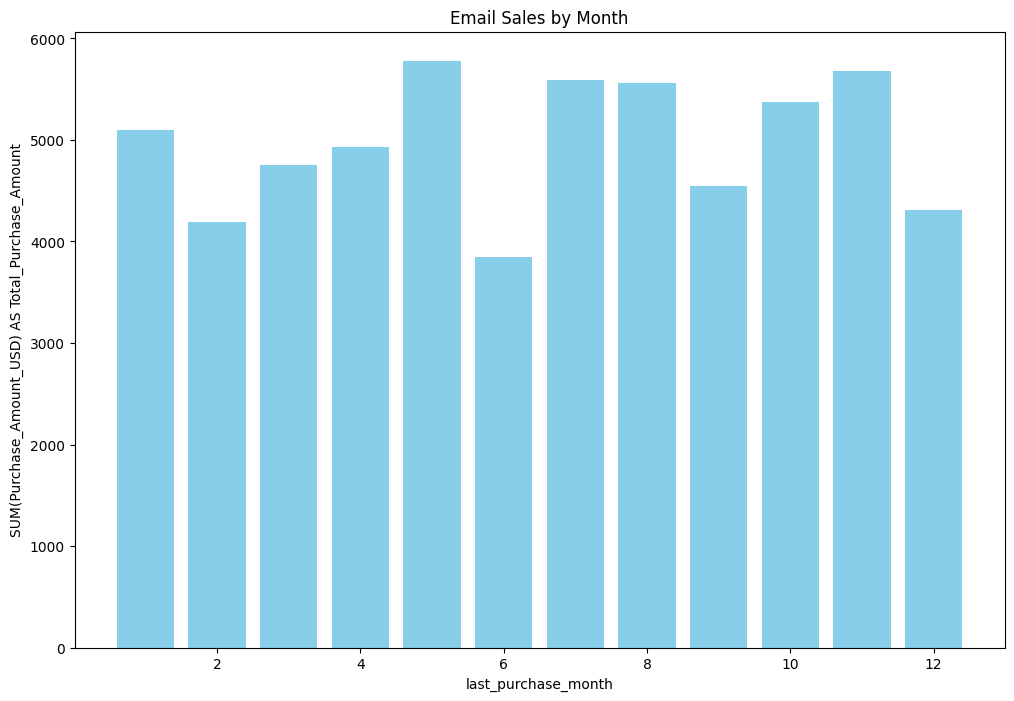

In [19]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_3 = '''
SELECT
    email_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    email_campaign, tiktok_campaign, first_purchase_month, last_purchase_month;
'''

product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with email campaigns (Total_Purchase_Amount) and group by the associated email campaign, sort by descending values
email_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['last_purchase_month']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("last_purchase_month")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Email Sales by Month")
plt.show()

It looks like May, July and October/November result in the most sales from email campaigns.

   tiktok_campaign  Total_Purchase_Amount
0   abandoned cart                    211
1   abandoned cart                    274
2   abandoned cart                    537
3   abandoned cart                     78
4   abandoned cart                    278
..             ...                    ...
67         welcome                    499
68         welcome                    439
69         welcome                    872
70         welcome                    710
71         welcome                    820

[72 rows x 2 columns]


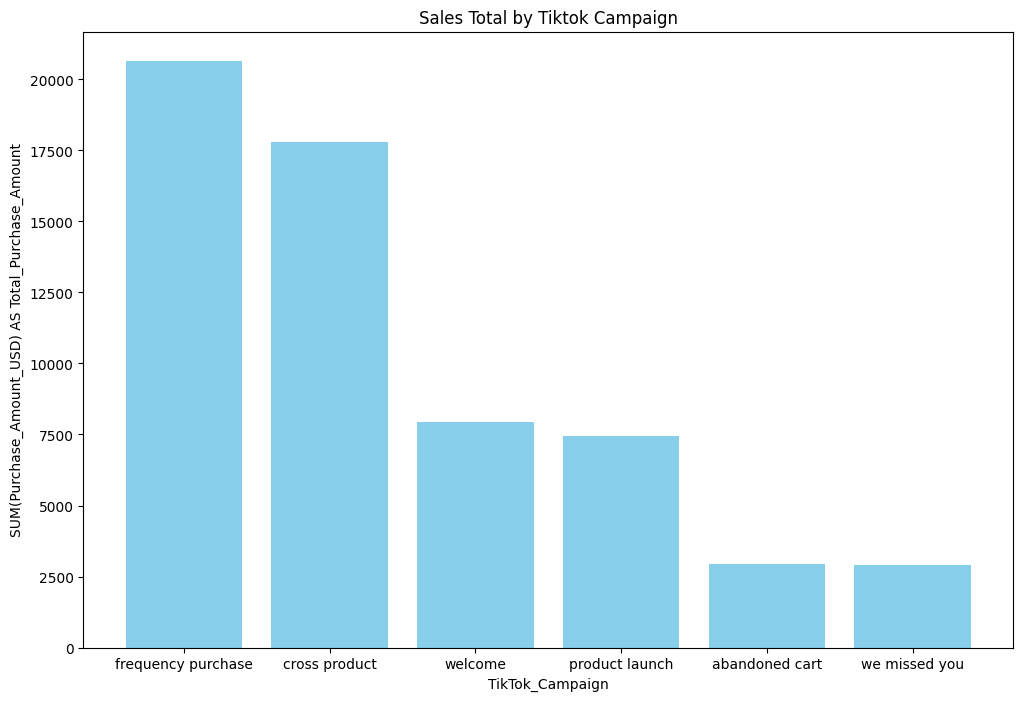

In [25]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_3 = '''
SELECT
    tiktok_campaign,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign, last_purchase_month;
'''

product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with email campaigns (Total_Purchase_Amount) and group by the associated email campaign, sort by descending values
tiktok_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['tiktok_campaign']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(tiktok_marketing_counts_sorted.index, tiktok_marketing_counts_sorted, color='skyblue')
plt.xlabel("TikTok_Campaign")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("Sales Total by Tiktok Campaign")
plt.show()

It looks like the Frequency Purhase and Cross Product campaigns generate the most sales from TikTok. 

   tiktok_campaign  last_purchase_month  Total_Purchase_Amount
0   abandoned cart                    1                    211
1   abandoned cart                    2                    274
2   abandoned cart                    3                    537
3   abandoned cart                    4                     78
4   abandoned cart                    5                    278
..             ...                  ...                    ...
67         welcome                    8                    499
68         welcome                    9                    439
69         welcome                   10                    872
70         welcome                   11                    710
71         welcome                   12                    820

[72 rows x 3 columns]


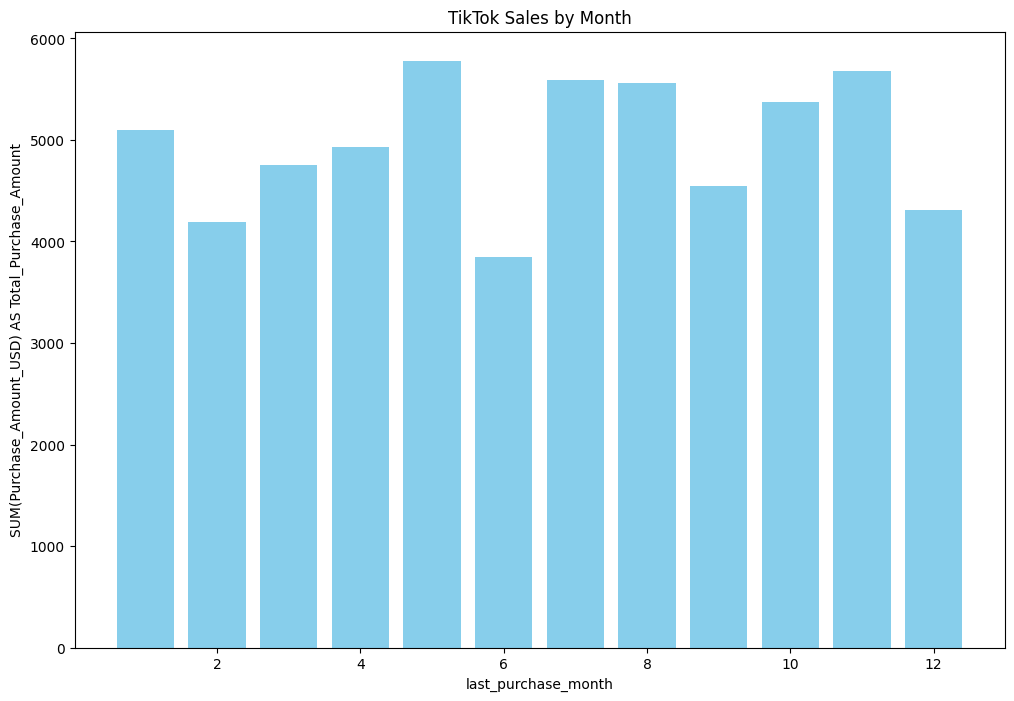

In [21]:
conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

product_information_3 = '''
SELECT
    tiktok_campaign, 
    last_purchase_month,
    SUM(Purchase_Amount_USD) AS Total_Purchase_Amount
FROM
    merged_data
GROUP BY
    tiktok_campaign,last_purchase_month;
'''

product_information_3 = pd.read_sql(product_information_3, conn)
print(product_information_3)

# Sort total sales with email campaigns (Total_Purchase_Amount) and group by the associated email campaign, sort by descending values
tiktok_marketing_counts_sorted = product_information_3['Total_Purchase_Amount'].groupby(product_information_3['last_purchase_month']).sum().sort_values(ascending=False)

# Bar chart of email campaigns
plt.figure(figsize=(12, 8))
plt.bar(email_marketing_counts_sorted.index, email_marketing_counts_sorted, color='skyblue')
plt.xlabel("last_purchase_month")
plt.ylabel("SUM(Purchase_Amount_USD) AS Total_Purchase_Amount")
plt.title("TikTok Sales by Month")
plt.show()

Similar to email, TikTok generates the  most sales during the months of May, July, August and November. 

In [16]:
#Marketing ROI #1: Compare CPAs for Tik Tok vs. Email 
#Remove dollar sign and CAST to FLOAT

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

marketing_roi_1 = '''
SELECT
  AVG(CAST(REPLACE(tiktok_cpa, '$', '') AS FLOAT)) AS avg_tiktok_cpa,
  AVG(CAST(REPLACE(email_cpa, '$', '') AS FLOAT)) AS avg_email_cpa
FROM merged_data; 
'''

marketing_roi_1 = pd.read_sql(marketing_roi_1, conn)
print(marketing_roi_1)

   avg_tiktok_cpa  avg_email_cpa
0         4.96912        5.11969


It looks like this e-commerce company had nearly equal CPAs across their two campaigns. In this instance, we want to focus on which campaigns had the highest sales or overall conversions.

        email_campaign     tiktok_campaign  Conversion_Count
0              welcome       cross product                28
1              welcome  frequency purchase                28
2   frequency purchase  frequency purchase                19
3       abandoned cart       cross product                15
4       abandoned cart  frequency purchase                12
5        cross product  frequency purchase                10
6              welcome             welcome                10
7       abandoned cart      product launch                 9
8   frequency purchase       cross product                 9
9   frequency purchase      product launch                 9
10             welcome      product launch                 9
11      abandoned cart             welcome                 7
12             welcome      abandoned cart                 7
13       cross product       cross product                 6
14  frequency purchase      abandoned cart                 4
15      product launch  

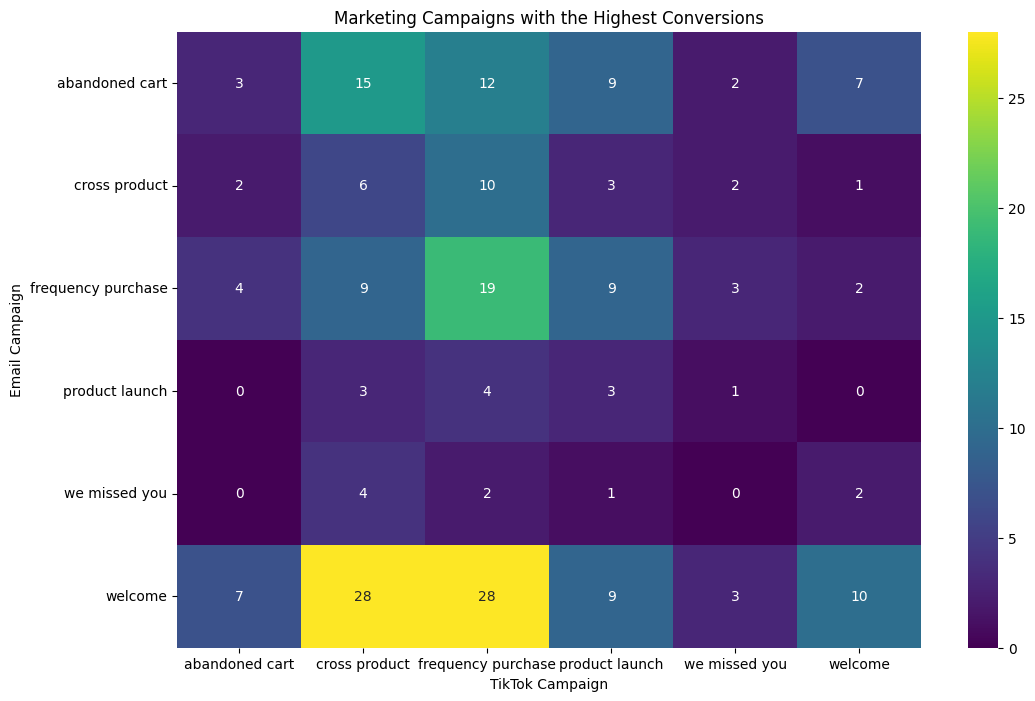

In [17]:
#Marketing ROI #2: Which marketing campaigns had the highest conversions?

conn = sqlite3.connect('cl_shopper_trends.db')
cursor = conn.cursor()

marketing_roi_2 = '''
SELECT
email_campaign,
tiktok_campaign,
COUNT(*) AS Conversion_Count
FROM
merged_data
WHERE
email_conversion = TRUE AND tiktok_conversion = TRUE
GROUP BY
email_campaign, tiktok_campaign
ORDER BY
Conversion_Count DESC;
'''

marketing_roi_2 = pd.read_sql(marketing_roi_2, conn)
print(marketing_roi_2)

pivot_table = marketing_roi_2.pivot_table(
    values='Conversion_Count',
    index='email_campaign',
    columns='tiktok_campaign',
    aggfunc='sum',
    fill_value=0
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='g')
plt.title('Marketing Campaigns with the Highest Conversions')
plt.xlabel('TikTok Campaign')
plt.ylabel('Email Campaign')
plt.show()

In yellow highlights the hotspots for conversions across both email and tiktok marketing campaigns. For example, the Welcome email campaign, the Cross Product TikTok campaign, and the Frequency Purchase TikTok campaign both resulted in 28 conversions. Something to consider when evaluating where marketing spend goes in the future.

Summary Findings

It looks like your highest sales come from Adult Males who live in the following states:
1. Delaware 
2. New Mexico 
3. Wyoming 
4. Alaska
5. Connecticut 

I would focus on putting marketing campaign spend towards Welcome campaigns for both TikTok and Email to incentivize new users with a discount code. I would incentivize returning users with Frequency Purchaser discount code. This is great for engaging and retaining existing high value customers. Line up these campaigns with months that have historical performed well with generating sales (May, June, July, August, October, November).

We could take this analysis a step further by analyzing sales data by state to understand customer segments by location, and analyzing website traffic to see how customer segments (Adult Male, Bi-Weekly buyer, etc.) aligns with purchasing behavior for this e-commerce company.  